# IBM Data Science Capstone Project
***Seattle Accident Forecasting***

## Introduction and Business Problem
_________

Driving on the road is inherently dangerous... but quantifying the risk can help us understand HOW dangerous it is and WHICH FACTORS can be mitigated. The goal is to identify ways to reduce risk of severe accidents (ie commute before 7am or avoid areas of high pedestrian traffic when roads are wet). This information should be presented in a manner that allows the decision makers to quantify relative risk levels.

The intended audience are transportation service providers such as Uber and Lyft drivers who can make a decision on whether to provide a service or not based on the level of risk for severe car accidents.

QUESTION 1: What factors contribute to risk for collision?

QUESTION 2: What factors contribute to higher risk for injury?

QUESTION 3: How can we mitigate the severity of automobile collisions?

QUESTION 4: Is there a statistically significant difference between the factors that lead to injury in collisions?

Example: "If you speed, you are __x more likely to have an injury in a crash"

There are three things that could factor into whether an injury occurs: 1) Timing, 2) Conditions, 3) Location. This analysis looks at how well we can predict an injury occuring given the CONDITIONS recorded with the dataset.


## Data
___

The data includes information on automobile collisions in Seattle since 2004. Factors include location, severity, persons involved, injuries, weather, lighting, road conditions, and speeding, among others.

SEVERITYCODE: Only '1' or '2' which correlates with SEVERITYDESC (1=property only, 2=injury)   

**Title:** Collisions—All Years

**Abstract:** All collisions provided by SPD and recorded by Traffic Records.

**Description:** This includes all types of collisions. Collisions will display at the intersection or mid-block of a segment.

**Link:** https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv

**Metadata:** https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf

**Timeframe:** 2004 to Present.

**Shape:** 194,673 x 38

**Contact Organization:** SDOT Traffic Management Division, Traffic Records Group

**Contact Person:** SDOT GIS Analyst (SDOT_IT_GIS@seattle.gov)

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv('Data-Collisions.csv', low_memory=False)
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [3]:
df.shape

(194673, 38)

In [4]:
#df.describe(include='all')

In [5]:
df.LIGHTCOND.value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [6]:
df.LIGHTCOND.isnull().sum()

5170

### 2.A Data Cleaning

In [7]:
#Removing unnecessary columns
df_clean = df.drop(['INCKEY', 'COLDETKEY', 'ST_COLDESC', 'SDOT_COLCODE', 'LOCATION', 'SDOT_COLDESC', 'SEVERITYCODE.1', 'CROSSWALKKEY', 'SEGLANEKEY','OBJECTID', 'REPORTNO', 'STATUS', 'INTKEY', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'INCDATE', 'JUNCTIONTYPE', 'SDOTCOLNUM'], axis=1)
print(df_clean.shape)
df_clean.head()

(194673, 20)


,SEVERITYCODE,X,Y,ADDRTYPE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDTTM,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR
0,2,-122.323148,47.703140,Intersection,Injury Collision,Angles,2,0,0,2,3/27/2013 2:54:00 PM,NaN,N,Overcast,Wet,Daylight,NaN,NaN,10,N
1,1,-122.347294,47.647172,Block,Property Damage Only Collision,Sideswipe,2,0,0,2,12/20/2006 6:55:00 PM,NaN,0,Raining,Wet,Dark - Street Lights On,NaN,NaN,11,N
2,1,-122.334540,47.607871,Block,Property Damage Only Collision,Parked Car,4,0,0,3,11/18/2004 10:20:00 AM,NaN,0,Overcast,Dry,Daylight,NaN,NaN,32,N
3,1,-122.334803,47.604803,Block,Property Damage Only Collision,Other,3,0,0,3,3/29/2013 9:26:00 AM,NaN,N,Clear,Dry,Daylight,NaN,NaN,23,N
4,2,-122.306426,47.545739,Intersection,Injury Collision,Angles,2,0,0,2,1/28/2004 8:04:00 AM,NaN,0,Raining,Wet,Daylight,NaN,NaN,10,N


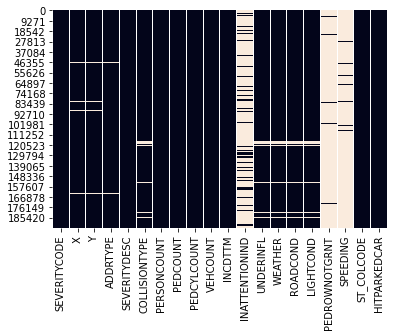

In [8]:
sns.heatmap(df_clean.isnull(), cbar=False)

In [9]:
df_clean['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

In [10]:
df_clean['X'].isnull().sum()

5334

In [11]:
# Drop rows without X,Y values:
df_clean.dropna(subset=['X', 'Y'], axis=0, inplace=True)
print(df_clean.shape)

(189339, 20)


In [12]:
print(df_clean['SEVERITYDESC'].isnull().sum())
df_clean['SEVERITYDESC'].value_counts()

0


Property Damage Only Collision    132221
Injury Collision                   57118
Name: SEVERITYDESC, dtype: int64

In [13]:
sev_bool = df_clean['SEVERITYCODE'] == 2
two_severe = df_clean[sev_bool]
#print(two_severe.head())
#print(two_severe.shape)
two_severe.SEVERITYDESC.value_counts()

Injury Collision    57118
Name: SEVERITYDESC, dtype: int64

In [14]:
# Drop the Severity Description column since it is the information as Severity Code
df_clean.drop('SEVERITYDESC', axis=1, inplace=True)
#df_clean.head()

In [15]:
print(df_clean['COLLISIONTYPE'].isnull().sum())
df_clean['COLLISIONTYPE'].value_counts()

4757


Parked Car    46381
Angles        34460
Rear Ended    32968
Other         22277
Sideswipe     18034
Left Turn     13624
Pedestrian     6551
Cycles         5378
Right Turn     2912
Head On        1997
Name: COLLISIONTYPE, dtype: int64

In [16]:
# Drop a pattern of values missing important data on collision and lighting etc
df_clean.dropna(subset=['COLLISIONTYPE', 'WEATHER'], axis=0, inplace=True)
print(df_clean.shape)

(184393, 19)


In [17]:
print(df_clean['PERSONCOUNT'].isnull().sum())
#df_clean['PERSONCOUNT'].value_counts()

0


In [18]:
zero_pers = df_clean[df_clean['PERSONCOUNT'] == 0]
zero_pers.VEHCOUNT.value_counts()

2     4197
1      747
3      381
4       79
5       18
6        5
0        5
7        2
11       1
9        1
Name: VEHCOUNT, dtype: int64

In [19]:
for value in df_clean['PERSONCOUNT']:
    if value == 0:
        df_clean['PERSONCOUNT'] = df_clean['VEHCOUNT']

In [20]:
print(df_clean['VEHCOUNT'].isnull().sum())
df_clean['VEHCOUNT'].value_counts()

0


2     143877
1      24485
3      12718
4       2380
5        520
0        196
6        143
7         42
8         15
9          9
11         5
10         2
12         1
Name: VEHCOUNT, dtype: int64

In [21]:
df_clean = df_clean[df_clean.VEHCOUNT != 0]
#df_clean.head()

In [22]:
print(df_clean['UNDERINFL'].isnull().sum())
df_clean['UNDERINFL'].value_counts()

0


N    97325
0    78008
Y     4986
1     3878
Name: UNDERINFL, dtype: int64

In [23]:
df_clean['UNDERINFL'] = df_clean['UNDERINFL'].str.replace('N', '0').str.replace('1', 'Y')
df_clean['UNDERINFL'] = df_clean['UNDERINFL'].replace('0', np.nan)

In [24]:
print(df_clean['WEATHER'].isnull().sum())
df_clean['WEATHER'].value_counts()

0


Clear                       108807
Raining                      31990
Overcast                     27102
Unknown                      13888
Snowing                        894
Other                          772
Fog/Smog/Smoke                 553
Sleet/Hail/Freezing Rain       112
Blowing Sand/Dirt               50
Severe Crosswind                24
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [25]:
df_clean['WEATHER'] = df_clean['WEATHER'].str.replace('Partly Cloudy', 'Clear')
df_clean['WEATHER'] = df_clean['WEATHER'].fillna('Unknown')

In [26]:
print(df_clean['LIGHTCOND'].isnull().sum())
df_clean['LIGHTCOND'].value_counts()

205


Daylight                    113369
Dark - Street Lights On      47234
Unknown                      12420
Dusk                          5759
Dawn                          2417
Dark - No Street Lights       1448
Dark - Street Lights Off      1146
Other                          188
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [27]:
df_clean['LIGHTCOND'] = df_clean['LIGHTCOND'].str.replace('Dark - No Street Lights', 'Dark - Street Lights Off')
df_clean['LIGHTCOND'] = df_clean['LIGHTCOND'].str.replace('Dark - Unknown Lighting', 'Dark - Street Lights Off')
df_clean['LIGHTCOND'] = df_clean['LIGHTCOND'].fillna('Unknown')

In [28]:
print(df_clean['HITPARKEDCAR'].isnull().sum())
df_clean['HITPARKEDCAR'].value_counts()

0


N    177530
Y      6667
Name: HITPARKEDCAR, dtype: int64

In [29]:
df_clean['HITPARKEDCAR'] = df_clean['HITPARKEDCAR'].replace('N', np.nan)

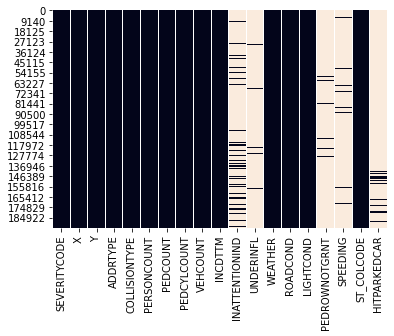

In [30]:
sns.heatmap(df_clean.isnull(), cbar=False)

In [31]:
df_clean['INCDTTM'] = pd.to_datetime(df_clean['INCDTTM'])
df_clean['DATE'] = df_clean['INCDTTM'].dt.date
df_clean['YEAR'] = df_clean['INCDTTM'].dt.year
df_clean['MONTH'] = df_clean['INCDTTM'].dt.month
df_clean['WEEK'] = df_clean['INCDTTM'].dt.week
df_clean['QUARTER'] = df_clean['INCDTTM'].dt.quarter
df_clean['DAYOFWEEK'] = df_clean['INCDTTM'].dt.weekday
df_clean['WEEKEND'] = df_clean['DAYOFWEEK'].isin([5,6]).astype('uint8')
week_code = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'} 
df_clean['DAYOFWEEK'] = df_clean['DAYOFWEEK'].map(week_code) 

month_code = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'} 
df_clean['MONTH'] = df_clean['MONTH'].map(month_code) 

quarter_code = {1:'Winter', 2:'Spring', 3:'Summer', 4:'Autumn'} 
df_clean['QUARTER'] = df_clean['QUARTER'].map(quarter_code) 

df_clean['HOUR'] = df_clean['INCDTTM'].dt.hour
#df_clean.head(20)

In [32]:
#Creating a variable for rush hour that includes 7-9 and 15-17 
df_clean['RUSHHOUR'] = df_clean['HOUR']
hour_code = {0:np.nan, 1:np.nan, 2:np.nan, 3:np.nan, 4:np.nan, 5:np.nan, 6:np.nan, 7:'Y', 
             8:'Y', 9:'Y', 10:np.nan, 11:np.nan, 12:np.nan, 13:np.nan, 14:np.nan, 15:'Y',
             16:'Y', 17:'Y', 18:np.nan, 19:np.nan, 20:np.nan, 21:np.nan, 22:np.nan, 23:np.nan} 
df_clean['RUSHHOUR'] = df_clean['RUSHHOUR'].map(hour_code) 

In [33]:
df_clean = df_clean.rename(columns = {'SEVERITYCODE':'INJURY', 'QUARTER':'SEASON'})
df_clean['INJURY'] = df_clean['INJURY'].replace(1,0)
df_clean['INJURY'] = df_clean['INJURY'].replace(2,1)

In [34]:
df_clean.reset_index(drop=True)

,INJURY,X,Y,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDTTM,...,HITPARKEDCAR,DATE,YEAR,MONTH,WEEK,SEASON,DAYOFWEEK,WEEKEND,HOUR,RUSHHOUR
0,1,-122.323148,47.703140,Intersection,Angles,2,0,0,2,2013-03-27 14:54:00,...,NaN,2013-03-27,2013,Mar,13,Winter,Wednesday,0,14,NaN
1,0,-122.347294,47.647172,Block,Sideswipe,2,0,0,2,2006-12-20 18:55:00,...,NaN,2006-12-20,2006,Dec,51,Autumn,Wednesday,0,18,NaN
2,0,-122.334540,47.607871,Block,Parked Car,3,0,0,3,2004-11-18 10:20:00,...,NaN,2004-11-18,2004,Nov,47,Autumn,Thursday,0,10,NaN
3,0,-122.334803,47.604803,Block,Other,3,0,0,3,2013-03-29 09:26:00,...,NaN,2013-03-29,2013,Mar,13,Winter,Friday,0,9,Y
4,1,-122.306426,47.545739,Intersection,Angles,2,0,0,2,2004-01-28 08:04:00,...,NaN,2004-01-28,2004,Jan,5,Winter,Wednesday,0,8,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184192,1,-122.290826,47.565408,Block,Head On,2,0,0,2,2018-11-12 08:12:00,...,NaN,2018-11-12,2018,Nov,46,Autumn,Monday,0,8,Y
184193,0,-122.344526,47.690924,Block,Rear Ended,2,0,0,2,2018-12-18 09:14:00,...,NaN,2018-12-18,2018,Dec,51,Autumn,Tuesday,0,9,Y
184194,1,-122.306689,47.683047,Intersection,Left Turn,2,0,0,2,2019-01-19 09:25:00,...,NaN,2019-01-19,2019,Jan,3,Winter,Saturday,1,9,Y
184195,1,-122.355317,47.678734,Intersection,Cycles,1,0,1,1,2019-01-15 16:48:00,...,NaN,2019-01-15,2019,Jan,3,Winter,Tuesday,0,16,Y


In [35]:
df_clean.to_csv('Data-Collisions-Clean.csv')

### 2.B Data Understading

In [36]:
print(df_clean.shape)
df_clean.describe()

(184197, 28)


,INJURY,X,Y,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,YEAR,WEEK,WEEKEND,HOUR
count,184197.000000,184197.000000,184197.000000,184197.000000,184197.000000,184197.000000,184197.000000,184197.000000,184197.000000,184197.000000,184197.000000
mean,0.303257,-122.330502,47.619537,1.975890,0.038426,0.028551,1.975890,2011.010777,26.768585,0.254896,11.467820
std,0.459666,0.030024,0.056230,0.552603,0.201571,0.167484,0.552603,4.642820,14.936080,0.435804,6.927341
min,0.000000,-122.419091,47.495573,1.000000,0.000000,0.000000,1.000000,2004.000000,1.000000,0.000000,0.000000
25%,0.000000,-122.348856,47.575873,2.000000,0.000000,0.000000,2.000000,2007.000000,14.000000,0.000000,7.000000
50%,0.000000,-122.330168,47.615361,2.000000,0.000000,0.000000,2.000000,2011.000000,27.000000,0.000000,13.000000
75%,1.000000,-122.311916,47.663835,2.000000,0.000000,0.000000,2.000000,2015.000000,40.000000,1.000000,17.000000
max,1.000000,-122.238949,47.734142,12.000000,6.000000,2.000000,12.000000,2020.000000,53.000000,1.000000,23.000000


In [37]:
# numericals_categoricals = ['PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'COLLISIONTYPE', 'ADDRTYPE', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING', 'HITPARKEDCAR', 'SEVERITYCODE']
# num_cat_pplot = sns.pairplot(data=df_clean[numericals_categoricalscals_categoricals],kind='reg',diag_kind='kde')

In [38]:
years = list(map(str, range(2004, 2021)))

In [39]:
print(plt.style.available)
mpl.style.use(['seaborn-talk'])

['Solarize_Light2', '_classic_test', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


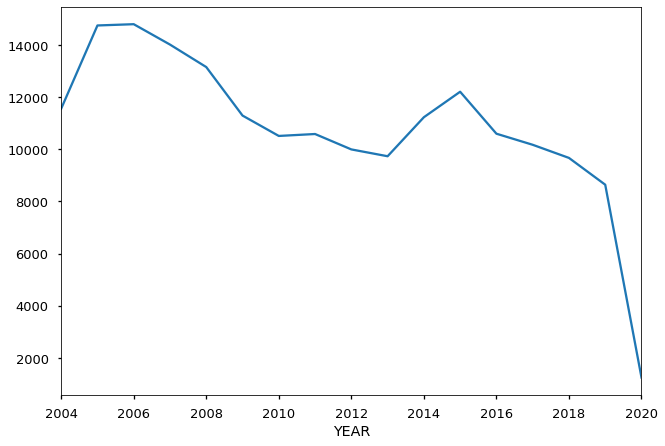

In [40]:
year_tot = df_clean.groupby('YEAR')['INJURY'].agg('size')
year_tot.plot(kind='line')

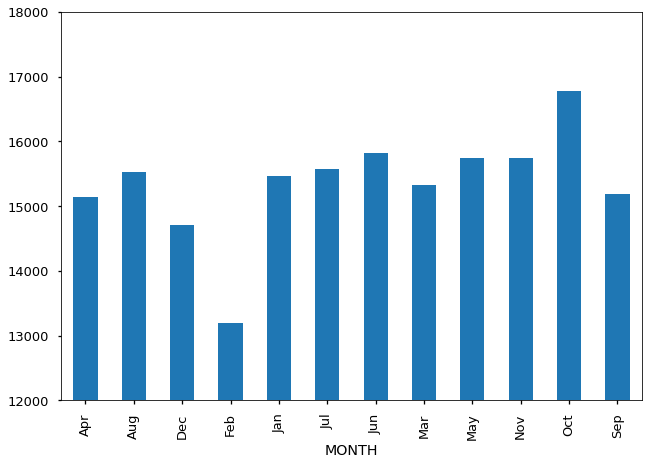

In [41]:
monthly_tot = df_clean.groupby('MONTH')['INJURY'].agg('size')
monthly_tot.plot(kind='bar', ylim=(12000, 18000))

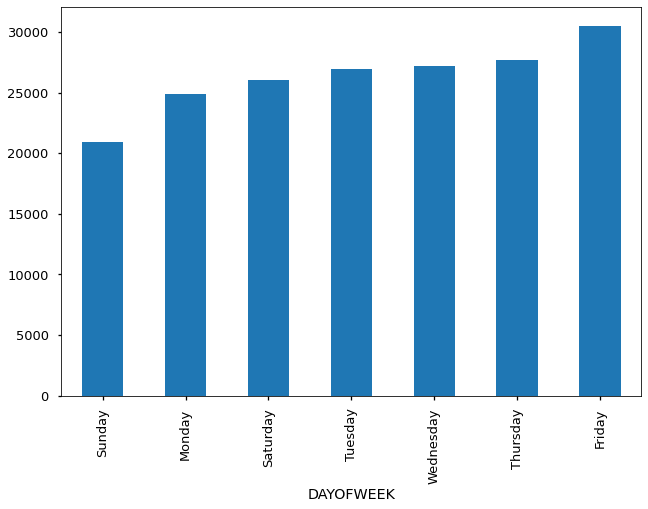

In [42]:
weekday_tot = df_clean.groupby('DAYOFWEEK')['INJURY'].agg('size')
weekday_tot.sort_values(inplace=True)
weekday_tot.plot(kind='bar')

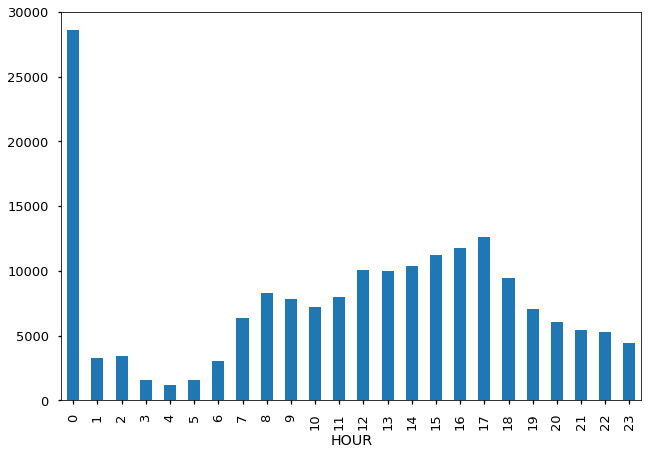

In [43]:
hourly_tot = df_clean.groupby('HOUR')['INJURY'].agg('size')
hourly_tot.plot(kind='bar')

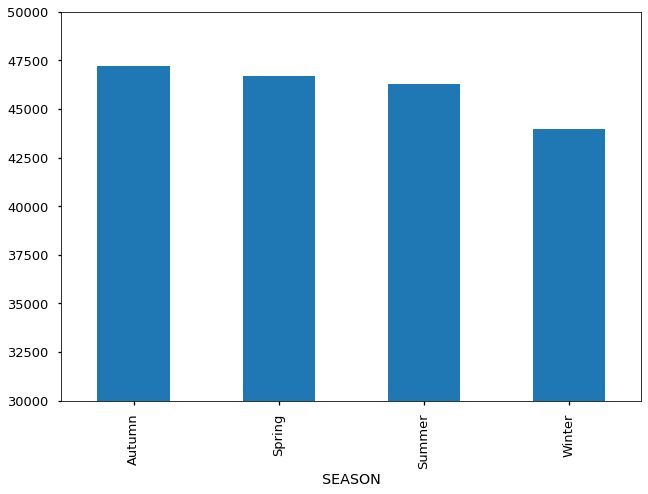

In [44]:
quarter_tot = df_clean.groupby('SEASON')['INJURY'].agg('size')
quarter_tot.plot(kind='bar', ylim=(30000, 50000))

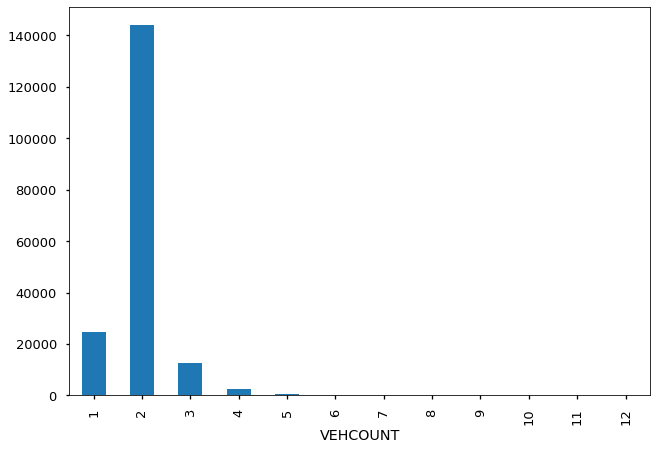

In [45]:
veh_count_tot = df_clean.groupby('VEHCOUNT')['INJURY'].agg('size')
veh_count_tot.plot(kind='bar')

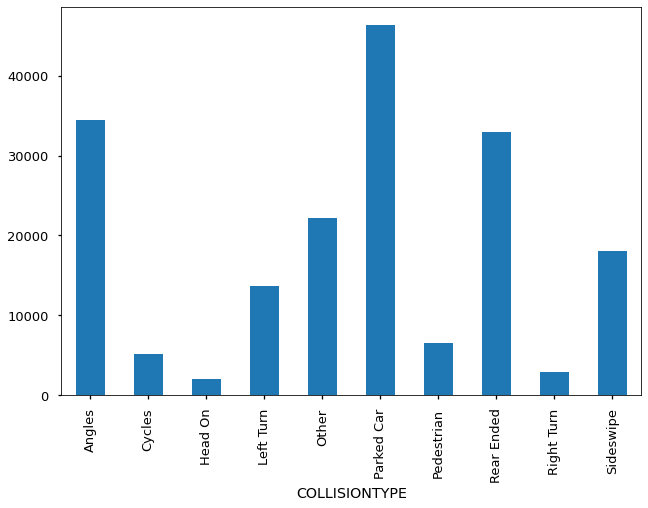

In [46]:
collision_tot = df_clean.groupby('COLLISIONTYPE')['INJURY'].agg('size')
collision_tot.plot(kind='bar')

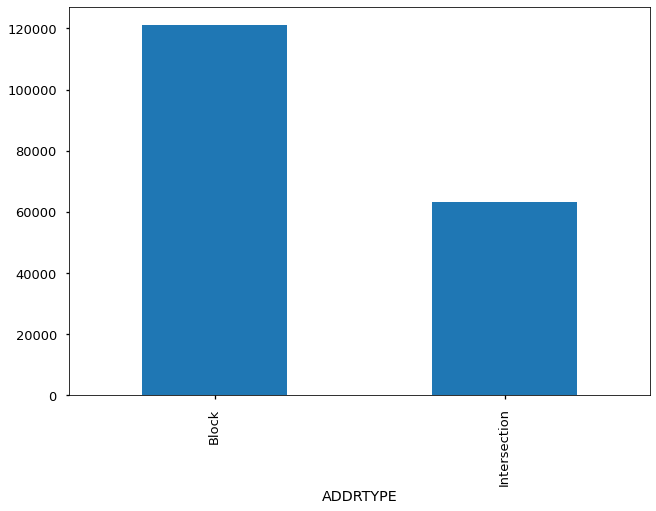

In [47]:
addrtype_tot = df_clean.groupby('ADDRTYPE')['INJURY'].agg('size')
addrtype_tot.plot(kind='bar')

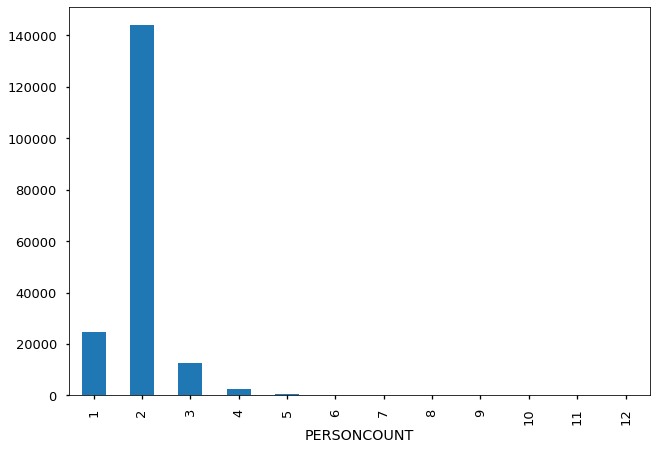

In [48]:
perscount_tot = df_clean.groupby('PERSONCOUNT')['INJURY'].agg('size')
perscount_tot.plot(kind='bar')

In [49]:
#Add indicators for pedestrians or bicylclists involved
df_clean['PEDINVLD'] = df_clean['PEDCOUNT']
ped_code = {0:0, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1} 
df_clean['PEDINVLD'] = df_clean['PEDINVLD'].map(ped_code) 

df_clean['CYCLEINVLD'] = df_clean['PEDCYLCOUNT']
cyl_code = {0:0, 1:1, 2:1} 
df_clean['CYCLEINVLD'] = df_clean['CYCLEINVLD'].map(cyl_code)

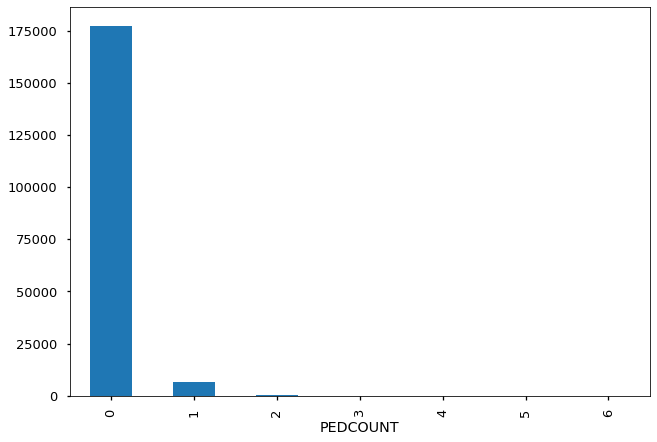

In [50]:
addrtype_tot = df_clean.groupby('PEDCOUNT')['INJURY'].agg('size')
addrtype_tot.plot(kind='bar')

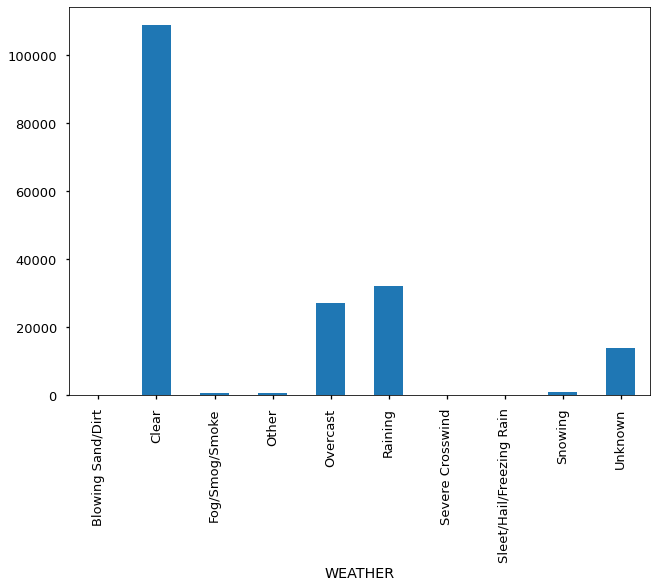

In [51]:
weather_tot = df_clean.groupby('WEATHER')['INJURY'].agg('size')
weather_tot.plot(kind='bar')

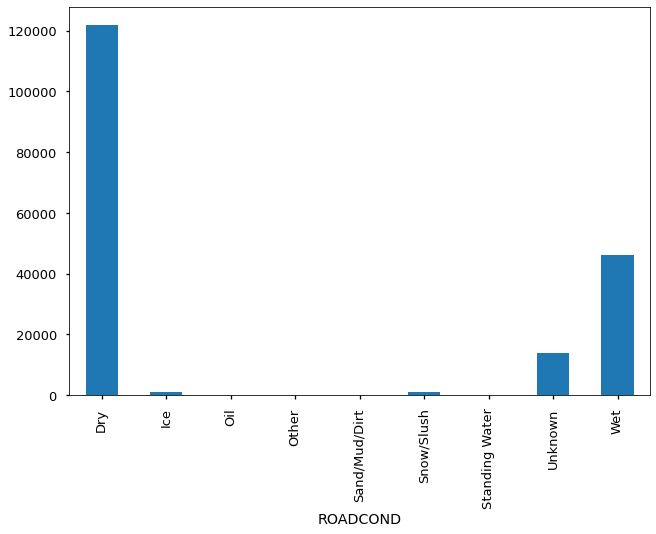

In [52]:
roadcond_tot = df_clean.groupby('ROADCOND')['INJURY'].agg('size')
roadcond_tot.plot(kind='bar')

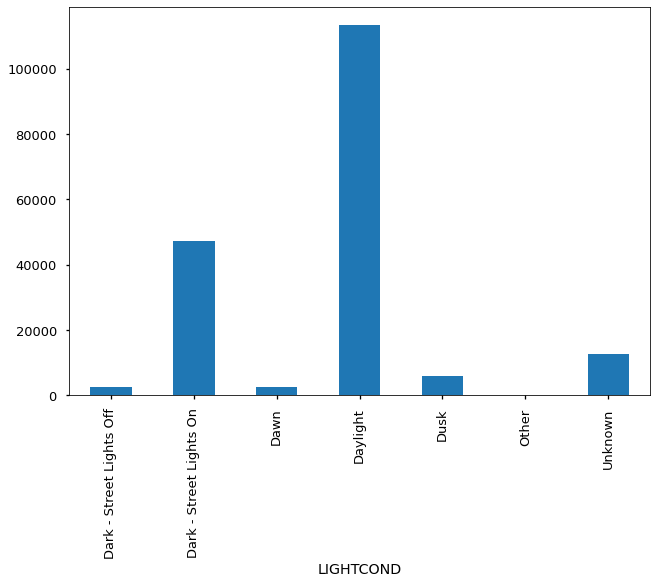

In [53]:
lightcond_tot = df_clean.groupby('LIGHTCOND')['INJURY'].agg('size')
lightcond_tot.plot(kind='bar')

### 2.C Data Preparation

In [54]:
sdot = df_clean.copy()
sdot = sdot[['INJURY', 'X', 'Y', 'DAYOFWEEK', 'MONTH', 'SEASON', 'ADDRTYPE', 'COLLISIONTYPE','WEATHER', 'ROADCOND', 'LIGHTCOND', 'INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING', 'HITPARKEDCAR', 'RUSHHOUR', 'PEDINVLD', 'CYCLEINVLD']]
INDICATORS = ['INATTENTIONIND', 'UNDERINFL', 'PEDROWNOTGRNT', 'SPEEDING', 'HITPARKEDCAR', 'RUSHHOUR', 'PEDINVLD', 'CYCLEINVLD']
CATEGORICALS = ['DAYOFWEEK', 'MONTH', 'SEASON', 'ADDRTYPE', 'COLLISIONTYPE','WEATHER', 'ROADCOND', 'LIGHTCOND']
LOCATION = ['X', 'Y']
LABEL = ['INJURY']
sdot[INDICATORS] = sdot[INDICATORS].replace('Y', 1)
sdot.fillna(0, inplace=True)
sdot.head()

,INJURY,X,Y,DAYOFWEEK,MONTH,SEASON,ADDRTYPE,COLLISIONTYPE,WEATHER,ROADCOND,LIGHTCOND,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,RUSHHOUR,PEDINVLD,CYCLEINVLD
0,1,-122.323148,47.703140,Wednesday,Mar,Winter,Intersection,Angles,Overcast,Wet,Daylight,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,0,-122.347294,47.647172,Wednesday,Dec,Autumn,Block,Sideswipe,Raining,Wet,Dark - Street Lights On,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,0,-122.334540,47.607871,Thursday,Nov,Autumn,Block,Parked Car,Overcast,Dry,Daylight,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,0,-122.334803,47.604803,Friday,Mar,Winter,Block,Other,Clear,Dry,Daylight,0.0,0.0,0.0,0.0,0.0,1.0,0,0
4,1,-122.306426,47.545739,Wednesday,Jan,Winter,Intersection,Angles,Raining,Wet,Daylight,0.0,0.0,0.0,0.0,0.0,1.0,0,0


In [55]:
#pivot table for INDICATORS
indicator_pivot = pd.pivot_table(data=sdot, values=INDICATORS, index='INJURY', aggfunc=np.mean)

In [56]:
indicator_pivot.loc['Factor'] = indicator_pivot.iloc[1]/indicator_pivot.iloc[0]
indicator_pivot

,CYCLEINVLD,HITPARKEDCAR,INATTENTIONIND,PEDINVLD,PEDROWNOTGRNT,RUSHHOUR,SPEEDING,UNDERINFL
INJURY,,,,,,,,
0,0.005205,0.048715,0.147563,0.005400,0.003553,0.303503,0.041991,0.042006
1,0.081670,0.007429,0.182459,0.109132,0.074330,0.341449,0.059364,0.062174
Factor,15.690650,0.152508,1.236481,20.210350,20.919660,1.125026,1.413736,1.480122


In [57]:
CATS_BINNED = pd.get_dummies(sdot[CATEGORICALS], drop_first=False)
sdot_binned = pd.concat([sdot[LABEL].reset_index(drop=True), sdot[INDICATORS].reset_index(drop=True), CATS_BINNED.reset_index(drop=True)], sort=False, axis=1) 

In [58]:
#sdot_binned.to_csv("sdot_binned.csv")
sdot_binned.head()

,INJURY,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,RUSHHOUR,PEDINVLD,CYCLEINVLD,DAYOFWEEK_Friday,...,ROADCOND_Standing Water,ROADCOND_Unknown,ROADCOND_Wet,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,1,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [59]:
corr = sdot_binned.corr()

In [60]:
top_factors = corr['INJURY'].sort_values(ascending=False)
top_factors.head(20)

INJURY                      1.000000
PEDINVLD                    0.253074
COLLISIONTYPE_Pedestrian    0.248152
CYCLEINVLD                  0.211616
COLLISIONTYPE_Cycles        0.210384
PEDROWNOTGRNT               0.208315
ADDRTYPE_Intersection       0.200620
COLLISIONTYPE_Rear Ended    0.130006
COLLISIONTYPE_Angles        0.094476
LIGHTCOND_Daylight          0.080944
ROADCOND_Dry                0.057995
COLLISIONTYPE_Left Turn     0.056402
WEATHER_Clear               0.051908
INATTENTIONIND              0.043961
UNDERINFL                   0.043315
ROADCOND_Wet                0.037761
SPEEDING                    0.037635
RUSHHOUR                    0.037549
WEATHER_Raining             0.035505
COLLISIONTYPE_Head On       0.029170
Name: INJURY, dtype: float64

In [61]:
X = sdot_binned.iloc[:,1:]
X.head()

,INATTENTIONIND,UNDERINFL,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,RUSHHOUR,PEDINVLD,CYCLEINVLD,DAYOFWEEK_Friday,DAYOFWEEK_Monday,...,ROADCOND_Standing Water,ROADCOND_Unknown,ROADCOND_Wet,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk,LIGHTCOND_Other,LIGHTCOND_Unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [62]:
y = sdot_binned.iloc[:,0]
y

0         1
1         0
2         0
3         0
4         1
         ..
184192    1
184193    0
184194    1
184195    1
184196    0
Name: INJURY, Length: 184197, dtype: int64

In [63]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (147357, 70) (147357,)
Test set: (36840, 70) (36840,)


In [64]:
sdot_binned_interaction = PolynomialFeatures(2, interaction_only=False, include_bias=False).fit_transform(X)
corr_int = pd.DataFrame(sdot_binned_interaction)
#.corr()
#top_factors_int = corr_int['INJURY'].sort_values(ascending=False)
#top_factors_int.head(20)

In [65]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
yhat = LR.predict(X_test)
yhat

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [67]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.71976608, 0.28023392],
       [0.10212417, 0.89787583],
       [0.64895789, 0.35104211],
       ...,
       [0.93128646, 0.06871354],
       [0.93149595, 0.06850405],
       [0.08011211, 0.91988789]])

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 2538  8725]
 [  760 24817]]


Confusion matrix, without normalization
[[ 2538  8725]
 [  760 24817]]


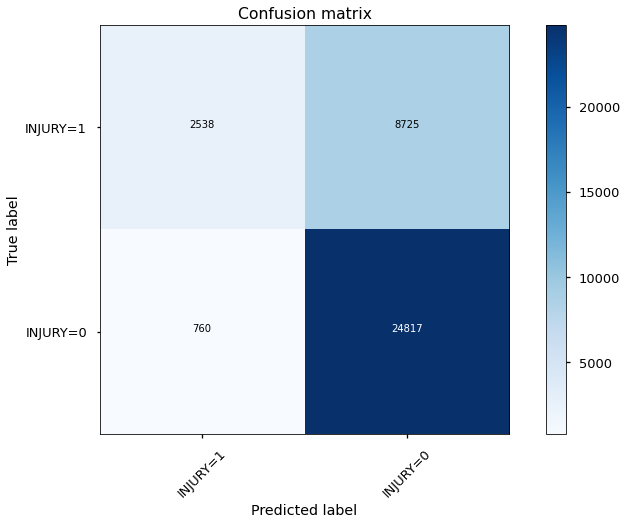

In [69]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['INJURY=1','INJURY=0'],normalize= False,  title='Confusion matrix')

In [70]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.74      0.97      0.84     25577
           1       0.77      0.23      0.35     11263

    accuracy                           0.74     36840
   macro avg       0.75      0.60      0.59     36840
weighted avg       0.75      0.74      0.69     36840



## 3. Methodology

**1. Based on the CONDITIONS provided, how much do the factors increase the probability of injury?**
- To answer this question, we format the conditions as indicator variables and build a pivot table to compare the collisions that led to injury versus those that were property-only damage. We also add a third row which represents the factor of liklihood for injury for each condition. The aggregate function we used was AVG since each variable was formatted as a binary already.

**2. What factors in the data correlate to injury risk?**
- To answer this we created indicator variables for all of the categorical variables, including time. We also ran a set using interaction terms for each of the 70 features (created 2500+ features). We picked out the top 25 features based on R^2 for each method.

**3. How well can we predict whether an injury will occur based on the conditions provided in the dataset?**
- To answert this, we used the binned categorical variables and ran a Logistic Regression to test performance on an out-of-sample dataset.

## 4. Results

**1. Based on the CONDITIONS provided, how much do the factors increase the probability of injury?**
- When pedestrians are involved (on foot or bike), the accident is 15-20x more likely to end up in injury--no surprise there.
- When the accident occurs while speeding, there is a 41% greater liklihood of injury.
- When under the influence, there is a 48% higher liklihood of injury.
- When inattention is indicated, the risk factor for injury is 1.24x.

**2. What factors in the data correlate to injury risk?**
- The top factors to correlate with injury are:
    1. Pedestrian/Cyclist Involved
    2. Occurs in an Intersection
    3. Rear-End Collision
    4. Angled Collision

**3. How well can we predict whether an injury will occur based on the conditions provided in the dataset?**
- The Logistic Regression has a precision of .74-.77 amd a recall of .97 on non-injury collisions. The recall on injury is just .23, likely due to the overlapping conditions for both levels of severity. 

## 5. Discussion

The data shows that the presence of pedestrians requires care becuase of the liklihood of injury from such collisions. We should also take care to reduce speed approaching intersections and maintain a safe distance from vehicles in front of us because all are risk factors for injury. 

## 6. Conclusion

Next steps in analysis would look at both the time and location data. There is also a bias in the data so we should create a test set that is balanced between observations with injury and those without.